<a href="https://colab.research.google.com/github/millenagena/Challenge-Data-Science-Alura-2ed/blob/main/2-Tratamento-dos-dados-e-Machine-Learning/tratamento_regressao_imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semana 2

Durante essa semana vamos realizar trabalhos de pessoas cientistas de dados.

O time de engenharia de dados da InsightPlaces disponibilizou a base de dados com algumas transformações já realizadas. No entanto, ainda é necessária a exploração e tratamento dessa base de dados para conseguirmos efetivamente partir pra criação dos nossos modelos de ML.

Sendo assim, vamos começar selecionando as features que fizerem mais sentido para nosso projeto e depois vamos realizar alguns tratamentos na base de dados. Ao finalizar isso, podemos utilizar os dados para a criação de um modelo de regressão que irá nos ajudar na precificação dos imóveis da InsightPlaces.

## Instalando pyspark

In [1]:
!pip install pyspark==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 199 kB 48.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=487bf80706fa9825d8b2db2dff13df45c379415389bdf6f778247d12185cd42c
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


## [SparkSession](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html)

O ponto de entrada para programar o Spark com a API Dataset e DataFrame.

Uma SparkSession pode ser utilizada para criar DataFrames, registrar DataFrames como tabelas, executar consultas SQL em tabelas, armazenar em cache e ler arquivos parquet. Para criar uma SparkSession, use o seguinte padrão de construtor:

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Regressão com Spark") \
    .getOrCreate()

spark

## Carregamento dos dados

In [3]:
!wget 'https://caelum-online-public.s3.amazonaws.com/challenge-spark/semana-2.zip' && unzip semana-2.zip -d dados/

--2022-12-05 15:23:11--  https://caelum-online-public.s3.amazonaws.com/challenge-spark/semana-2.zip
Resolving caelum-online-public.s3.amazonaws.com (caelum-online-public.s3.amazonaws.com)... 52.216.166.35, 52.216.221.201, 54.231.199.185, ...
Connecting to caelum-online-public.s3.amazonaws.com (caelum-online-public.s3.amazonaws.com)|52.216.166.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2763652 (2.6M) [application/zip]
Saving to: ‘semana-2.zip’

semana-2.zip        100%[===================>]   2.63M  14.1MB/s    in 0.2s    

2022-12-05 15:23:11 (14.1 MB/s) - ‘semana-2.zip’ saved [2763652/2763652]

Archive:  semana-2.zip
   creating: dados/dataset_transformado_parquet/
  inflating: dados/dataset_transformado_parquet/_SUCCESS  
  inflating: dados/dataset_transformado_parquet/._SUCCESS.crc  
  inflating: dados/dataset_transformado_parquet/part-00000-00341ba7-0a7c-4fef-a81e-1066725a64b1-c000.snappy.parquet  
  inflating: dados/dataset_transformado_parquet/.p

In [4]:
dados = spark.read.parquet("dados/dataset_transformado_parquet")
dados.show(5)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|        zona|condominio|iptu| tipo| valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|03a386b6-7ab8-4ef...|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|       Usado| Apartamento|Residencial|   1|    Realengo|  Zona Oeste|       285|null|Venda| 22999|
|1fe78d41-b8e0-4d2...|    0|        44|       44|        1|                  []|      2|     0|       Usado| Apartamento|Residencial|   0|       Irajá|  Zona Norte|       170|   0|Venda|110000|
|1fa1c1e5-e98c-433...|    4|  

## Seleção de features

Vamos remover algumas colunas que possuem apenas um único valor. Essas colunas estão dessa forma devido aos filtros que foram realizados na base de dados durante a semana 1.

In [5]:
dados.select("tipo").distinct().show(5)

+-----+
| tipo|
+-----+
|Venda|
+-----+



In [6]:
dados.select("tipo_anuncio").distinct().show(5)

+------------+
|tipo_anuncio|
+------------+
|       Usado|
+------------+



In [7]:
dados.select("tipo_unidade").distinct().show(5)

+------------+
|tipo_unidade|
+------------+
| Apartamento|
+------------+



In [8]:
dados.select("tipo_uso").distinct().show(5)

+-----------+
|   tipo_uso|
+-----------+
|Residencial|
+-----------+



Além dessas colunas, vamos analisar as colunas "area_total" e "area_util"

In [9]:
dados.select("area_total", "area_util").show(5)

+----------+---------+
|area_total|area_util|
+----------+---------+
|        43|       43|
|        44|       44|
|      null|       55|
|      null|       55|
|      null|       50|
+----------+---------+
only showing top 5 rows



In [10]:
from pyspark.sql import functions as f

dados_without_na = dados\
    .select('area_util', 'area_total')\
    .na\
    .drop()

quantidade_total = dados_without_na.count()
quantidade_iguais = dados_without_na.filter(f.col('area_util') == f.col('area_total')).count()
quantidade_distintas = quantidade_total - quantidade_iguais

print(f"Quantidade de linhas: {quantidade_total}")
print(f"Quantidade de linhas com area_util == area_total: {quantidade_iguais}")
print(f"Quantidade de linhas diferentes: {quantidade_distintas}")

Quantidade de linhas: 57368
Quantidade de linhas com area_util == area_total: 55384
Quantidade de linhas diferentes: 1984


Podemos notar que de 57368 linhas, temos que 55384 linhas possuem os mesmos valores tanto na coluna "area_total" quanto na coluna "area_util". Dessa forma, temos que a maioria das informações dessas colunas são as mesmas e não é necessário mantermos as duas em nossa base de dados. Para escolhermos qual dessas colunas será removida, vamos analisar a quantidade de dados nulos em cada uma delas.

In [11]:
colunas = ["area_total", "area_util"]

dados\
    .select([f.count(f.when(dados[c].isNull(), True)).alias(c) for c in colunas])\
    .show()

+----------+---------+
|area_total|area_util|
+----------+---------+
|      9194|        0|
+----------+---------+



Analisando o resultado acima, podemos notar que a coluna "area_total" possui 9194 dados nulos, enquanto a coluna "area_util" não possui nenhuma. Dessa forma, vamos optar por remover a coluna "area_total" da nossa base de dados.

In [12]:
dados.\
    drop("area_total", "tipo_anuncio", "tipo_unidade", "tipo_uso", "tipo")\
    .show(5)

+--------------------+-----+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|iptu| valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|  null|   1|    Realengo|  Zona Oeste|       285|null| 22999|
|1fe78d41-b8e0-4d2...|    0|       44|        1|                  []|      2|     0|   0|       Irajá|  Zona Norte|       170|   0|110000|
|1fa1c1e5-e98c-433...|    4|       55|        1|                  []|      2|     0|   1|      Cosmos|  Zona Oeste|      null|null|115000|
|a6ab01ae-3d40-40e...|    2|       55|        1|                  []|      2|     0|   0|Tomás Coelho|  Zona Norte|      null|null|115000|
|1d8ff7a2-16bd-4e3...|    0

In [13]:
# remover as colunas area_total, tipo_anuncio, tipo_unidade, tipo_uso, tipo

dataset = dados.\
                drop("area_total", "tipo_anuncio", "tipo_unidade", "tipo_uso", "tipo")

dataset.show(5)

+--------------------+-----+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|        zona|condominio|iptu| valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+------------+------------+----------+----+------+
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|  null|   1|    Realengo|  Zona Oeste|       285|null| 22999|
|1fe78d41-b8e0-4d2...|    0|       44|        1|                  []|      2|     0|   0|       Irajá|  Zona Norte|       170|   0|110000|
|1fa1c1e5-e98c-433...|    4|       55|        1|                  []|      2|     0|   1|      Cosmos|  Zona Oeste|      null|null|115000|
|a6ab01ae-3d40-40e...|    2|       55|        1|                  []|      2|     0|   0|Tomás Coelho|  Zona Norte|      null|null|115000|
|1d8ff7a2-16bd-4e3...|    0

## Convertendo os tipos das colunas

Ao analisarmos a estrutura da nossa base de dados, vamos notar que os tipos dos dados de cada coluna estão incorretos e por isso é necessário convertê-los.

Dessa forma, vamos converter o tipo de colunas numéricas, como "andar", "banheiros", "suites" e "quartos" para o tipo inteiro. Além disso vamos converter as colunas "area_util", "condominio", "iptu" e "valor" para o tipo double.

In [14]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)



In [15]:
from pyspark.sql.types import IntegerType, DoubleType

In [16]:
dataset\
    .withColumn('andar', dados['andar'].cast(IntegerType()))\
    .withColumn('area_util', dados['area_util'].cast(DoubleType()))\
    .withColumn('banheiros', dados['banheiros'].cast(IntegerType()))\
    .withColumn('quartos', dados['quartos'].cast(IntegerType()))\
    .withColumn('suites', dados['suites'].cast(IntegerType()))\
    .withColumn('condominio', dados['condominio'].cast(DoubleType()))\
    .withColumn('vaga', dados['vaga'].cast(IntegerType()))\
    .withColumn('iptu', dados['iptu'].cast(DoubleType()))\
    .withColumn('valor', dados['valor'].cast(DoubleType()))\
    .printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



In [17]:
dataset = dataset\
    .withColumn('andar', dados['andar'].cast(IntegerType()))\
    .withColumn('area_util', dados['area_util'].cast(IntegerType()))\
    .withColumn('banheiros', dados['banheiros'].cast(IntegerType()))\
    .withColumn('quartos', dados['quartos'].cast(IntegerType()))\
    .withColumn('suites', dados['suites'].cast(DoubleType()))\
    .withColumn('condominio', dados['condominio'].cast(DoubleType()))\
    .withColumn('vaga', dados['vaga'].cast(DoubleType()))\
    .withColumn('iptu', dados['iptu'].cast(DoubleType()))\
    .withColumn('valor', dados['valor'].cast(DoubleType()))

## Tratamento da coluna "caracteristicas"

A coluna "caracteristicas" possui listas de strings como conteúdo de suas linhas. No entanto, algumas dessas listas estão sem elementos.

Vamos transformar essas listas sem elementos em valores nulos

In [18]:
# visualizando os elementos únicos das listas dessa coluna
dataset.select(f.explode("caracteristicas")).distinct().collect()

[Row(col='Condomínio fechado'),
 Row(col='Playground'),
 Row(col='Portão eletrônico'),
 Row(col='Piscina'),
 Row(col='Animais permitidos'),
 Row(col='Portaria 24h'),
 Row(col='Elevador'),
 Row(col='Academia'),
 Row(col='Salão de festas'),
 Row(col='Churrasqueira')]

In [19]:
dataset = dataset.withColumn('caracteristicas', f.when((f.size(f.col('caracteristicas')) == 0), f.lit(None)).otherwise(f.col('caracteristicas')))
dataset.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+------+--------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|        zona|condominio|  iptu|   valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+------+--------+
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|  null| 1.0|            Realengo|  Zona Oeste|     285.0|  null| 22999.0|
|1fe78d41-b8e0-4d2...|    0|       44|        1|                null|      2|   0.0| 0.0|               Irajá|  Zona Norte|     170.0|   0.0|110000.0|
|1fa1c1e5-e98c-433...|    4|       55|        1|                null|      2|   0.0| 1.0|              Cosmos|  Zona Oeste|      null|  null|115000.0|
|a6ab01ae-3d40-40e...|    2|       55|        1|                null|      2|   0.0| 0.0|     

## Tratando dados faltantes

Ao analisarmos a estrutura da nossa base de dados, vamos notar que ela possui diversos dados faltantes. Dessa maneira, é importante lidarmos com isso pois modelos de Machine Learning não costumam trabalhar corretamente com dados nulos.

In [20]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: double (nullable = true)
 |-- vaga: double (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



Vamos começar analisando a quantidade de dados nulos em cada uma das nossas colunas

Existem diferentes maneiras de contabilizar a quantidade de dados nulos utilizando PySpark. Nas próximas células, vamos apresentar 3 soluções diferentes, sendo que a terceira delas não abrange a coluna `caracteristicas`

In [21]:
# Solução 01

dicionarios_nulos = {col:dataset.filter(dataset[col].isNull()).count() for col in dataset.columns}
dicionarios_nulos

{'id': 0,
 'andar': 0,
 'area_util': 0,
 'banheiros': 0,
 'caracteristicas': 12736,
 'quartos': 0,
 'suites': 5554,
 'vaga': 3017,
 'bairro': 0,
 'zona': 0,
 'condominio': 2371,
 'iptu': 7199,
 'valor': 0}

In [22]:
# Solução 02

dataset\
    .select([f.count(f.when(dataset[c].isNull(), True)).alias(c) for c in dataset.columns])\
    .show()

+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|  0|    0|        0|        0|          12736|      0|  5554|3017|     0|   0|      2371|7199|    0|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



In [23]:
# Solução 03 - sem a coluna "caracteristicas"

dataset\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns if c != 'caracteristicas' ])\
    .show()

+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_util|banheiros|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+
|  0|    0|        0|        0|      0|  5554|3017|     0|   0|      2371|7199|    0|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+



Para lidarmos com os dados nulos das colunas numéricas, optamos por substituí-los pelo número 0.

In [24]:
dataset\
    .select('*')\
    .na\
    .fill(0)\
    .show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+------+--------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|        zona|condominio|  iptu|   valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+------------+----------+------+--------+
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|   0.0| 1.0|            Realengo|  Zona Oeste|     285.0|   0.0| 22999.0|
|1fe78d41-b8e0-4d2...|    0|       44|        1|                null|      2|   0.0| 0.0|               Irajá|  Zona Norte|     170.0|   0.0|110000.0|
|1fa1c1e5-e98c-433...|    4|       55|        1|                null|      2|   0.0| 1.0|              Cosmos|  Zona Oeste|       0.0|   0.0|115000.0|
|a6ab01ae-3d40-40e...|    2|       55|        1|                null|      2|   0.0| 0.0|     

In [25]:
dataset = dataset\
    .select('*')\
    .na\
    .fill(0)

Nesse momento não vamos nos preocupar em tratar os dados nulos da coluna "caracteristicas". Faremos isso mais a frente quando formos realizar a preparação dos nossos dados para o modelo de Machine Learning.

Outra coluna que devemos nos atentar é a `zona`. Ao verificarmos os dados únicos dessa coluna, vamos notar que existe uma string vazia como conteúdo dessa coluna.

In [26]:
dataset\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
|            |   11|
+------------+-----+



Podemos notar que apenas 11 das linhas da nossa base de dados possui essa string vazia. Sendo assim, podemos desconsiderar essas linhas da nossa base de dados.

In [27]:
dataset = dataset\
    .where(f.col('zona') != '')

## Preparação dos dados para ML 

[Documentação da Biblioteca Pyspark ML](https://spark.apache.org/docs/2.3.1/api/python/pyspark.ml.html)

Para conseguirmos utilizar nossos dados em modelos de Machine Learning, é necessário realizarmos algumas técnicas, como a transformação de variáveis categóricas em binárias.

Além disso, no caso de modelos do PySpark nós também utilizaremos a técnica de vetorização dos dados.

## Variáveis Dummy

Esse processo consiste em transformar as variáveis categóricas em binárias. Precisamos realizar isso, pois modelos de regressão não conseguem lidar com variáveis textuais.

In [28]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: double (nullable = false)
 |-- vaga: double (nullable = false)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = false)
 |-- iptu: double (nullable = false)
 |-- valor: double (nullable = false)



In [29]:
dataset.select("*", f.explode("caracteristicas").alias("caracteristica")).show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+------------+----------+----------+----+--------+------------------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|      bairro|      zona|condominio|iptu|   valor|    caracteristica|
+--------------------+-----+---------+---------+--------------------+-------+------+----+------------+----------+----------+----+--------+------------------+
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|   0.0| 1.0|    Realengo|Zona Oeste|     285.0| 0.0| 22999.0|     Churrasqueira|
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|   0.0| 1.0|    Realengo|Zona Oeste|     285.0| 0.0| 22999.0|          Academia|
|03a386b6-7ab8-4ef...|    0|       43|        1|[Churrasqueira, A...|      2|   0.0| 1.0|    Realengo|Zona Oeste|     285.0| 0.0| 22999.0|        Playground|
|03a386b6-7ab8-4ef...|    0|       43|        1|[Chu

Vamos transformar cada uma das características da coluna `caracteristicas` em colunas separadas. Assim, nas linhas que possuírem a característica vamos preencher com o valor "1" e caso contrário vamos colocar o valor "0"

In [30]:
dataset\
    .select("*", f.explode("caracteristicas").alias("cara"))\
    .groupBy("id")\
    .pivot('cara')\
    .agg(f.lit(1))\
    .na\
    .fill(0)\
    .show(truncate=False)

+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|id                                  |Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|fd96bbd5-d631-416a-9f84-29091cefe14c|1       |1                 |1            |1                 |1       |1      |1         |1           |1                |1              |
|bfffedfe-99e7-4aed-9a9f-f766225a0f1f|0       |1                 |1            |1                 |1       |0      |1         |0           |1                |1              |
|fcb67af3-5601-415f-9d1f-75280923a4e3|1       |1                 |1            |0                 |0       |1      |1        

In [31]:
caracteristicas = dataset\
    .select("*", f.explode("caracteristicas").alias("cara"))\
    .groupBy("id")\
    .pivot('cara')\
    .agg(f.lit(1))

Da mesma forma que fizemos com a coluna `caracteristicas` anteriormente, iremos fazer agora com a coluna `zona`. Vamos transformar cada uma das zonas da coluna `zona` em colunas separadas. Assim, nas linhas que pertencerem a uma zona específica vamos preencher com o valor "1" e caso contrário vamos colocar o valor "0"

In [32]:
zona = dataset\
    .groupBy("id")\
    .pivot('zona')\
    .agg(f.lit(1))

In [33]:
dataset.show(10, truncate=False)

+------------------------------------+-----+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+-------+------+----+-----------------------+------------+----------+------+--------+
|id                                  |andar|area_util|banheiros|caracteristicas                                                                                                                |quartos|suites|vaga|bairro                 |zona        |condominio|iptu  |valor   |
+------------------------------------+-----+---------+---------+-------------------------------------------------------------------------------------------------------------------------------+-------+------+----+-----------------------+------------+----------+------+--------+
|03a386b6-7ab8-4eff-891d-f8a16efc1989|0    |43       |1        |[Churrasqueira, Academia, Playground, Salão de festas, Condomínio fechado, Portão eletrônico, Portaria 24

Como salvamos os tratamentos feitos anteriormente nas colunas `caracteristicas` e `zona` em variáveis separadas, vamos agora juntar o conteúdo dessas variáveis com o conjunto de dados completo.

In [34]:
# contando a quantidade total de linhas do dataset original
count_rows_original = dataset.count()

In [35]:
# juntando os dados utilizando o metodo join
dataset = dataset\
    .join(zona, 'id', how='inner')\
    .join(caracteristicas, 'id', how='left')\
    .drop('zona', 'cara', 'caracteristicas')\
    .na\
    .fill(0)

In [36]:
# comparando se o join funcionou corretamente e ainda temos a mesma quantidade de linhas do dataset original
print("Quantidade de linhas antes: ", count_rows_original)
print("Quantidade de linhas depois: ", dataset.count())
print("Quantidade de linhas perdidas: ", count_rows_original - dataset.count())

Quantidade de linhas antes:  66551
Quantidade de linhas depois:  66551
Quantidade de linhas perdidas:  0


In [37]:
dataset.show(5)

+--------------------+-----+---------+---------+-------+------+----+-----------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|     bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+-----------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|02fba6ef-a691-442...|    3|       64|        1|      2|   2.0| 1.0|Jacarepaguá|     784.0|  80.0| 380000.0|           0|         0| 

In [38]:
# Conferindo o ID e se as colunas dummies referentes a esse ID estão corretas.

dataset.filter(f.col('id')=="be269ddf-a4a3-4a72-bd54-93cdccf512dd").show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio|iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|be269ddf-a4a3-4a7...|    0|       45|        1|      2|   0.0| 1.0|Campo Grande|     356.0| 0.0|140000.0|           0|         0|         

## Salvando os dados em parquet

Até aqui criamos uma base dados ideal para utilizar em modelos de machine learning. É importante exportar ela para conseguirmos utilizá-la em outros modelos e para treinar novamente nosso modelo, caso seja necessário. Além disso, também utilizaremos essa base de dados nas próximas semanas do projeto.

In [39]:
dataset.write.parquet("dados_salvos/dataset_ml_regressao")

## Extra: Análise de correlação

Vamos analisar a correlação entre as variáveis numéricas da nossa base de dados. Esse processo é importante para detectarmos redundância entre as variáveis.

In [40]:
from pyspark.ml.stat import Correlation

In [41]:
# Array das características: array_caracteristicas

array_zona = ['Zona Central', 'Zona Norte', 'Zona Oeste', 'Zona Sul']
array_caracteristicas = ['Condomínio fechado',
                        'Playground',
                        'Portão eletrônico',
                        'Piscina',
                        'Animais permitidos',
                        'Portaria 24h',
                        'Elevador',
                        'Academia',
                        'Salão de festas',
                        'Churrasqueira']

In [42]:
input_col_corr = [i for i in dataset.columns if i not in ['id', 'bairro'] + array_caracteristicas + array_zona]

In [43]:
input_col_corr

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor']

In [44]:
from pyspark.ml.feature import VectorAssembler

In [45]:
assembler = VectorAssembler(inputCols=input_col_corr, outputCol='features')

In [46]:
df = assembler.transform(dataset).select("features")

In [47]:
# A correlação estará na Matriz Densa

correlation = Correlation.corr(df,"features","pearson").collect()[0][0]

In [48]:
# Para converter a matriz densa em DataFrame
rows = correlation.toArray().tolist()
df = spark.createDataFrame(rows,input_col_corr)

In [49]:
df.show(5)

+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               andar|           area_util|          banheiros|            quartos|              suites|                vaga|          condominio|                iptu|               valor|
+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|0.020674885718290938|0.01757715331670636|0.01008345278433944|0.024274113790933662|0.018271843474798374| 0.00661793024888357|3.810955786364769E-4|0.016145590401857667|
|0.020674885718290938|                 1.0| 0.6710305514515004| 0.6740755967299843|  0.6201287358481448| 0.47192843823228026| 0.04567656570607291|0.021337139034348793|  0.7586357636187985|
| 0.01757715331670636|  0.6710305514515004|            

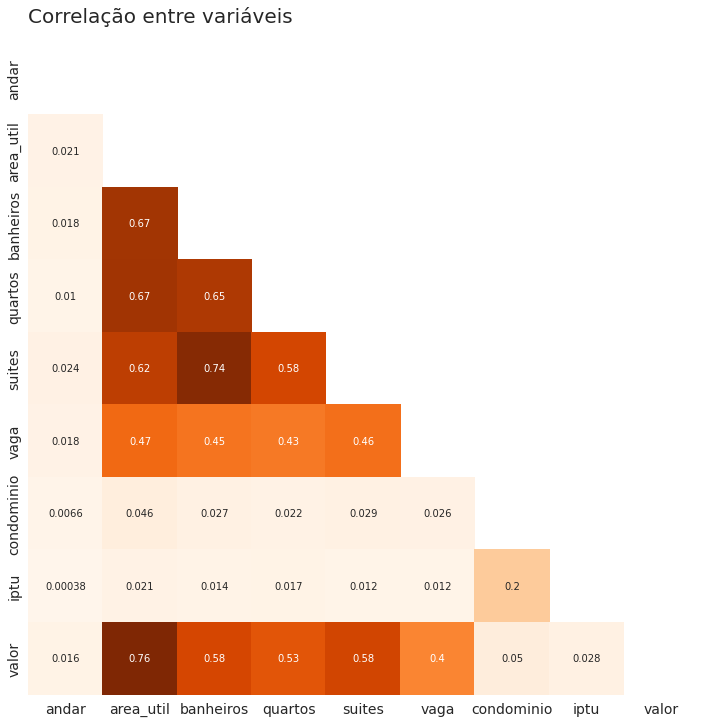

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.toPandas().set_index([input_col_corr])
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask, fmt=".2",  annot=True, cbar=False, cmap='Oranges')
    ax.tick_params(labelsize=14)
    ax.set_title('Correlação entre variáveis', fontsize=20, loc='left', pad=20)

Podemos perceber, pelo gráfico acima, que a variável `valor` possui uma correlação mais alta com as variáveis `area_util` e `banheiros`, porém essa correlação não é tão alta. Dessa forma, não vamos descartar nenhuma dessas variáveis.

## Vetorizando os dados

Para utilizarmos nossa base de dados em modelos de machine learning do PySpark, vamos precisar utilizar uma técnica chamada de **vetorização dos dados**, para isso utilizaremos a classe `VectorAssembler` da biblioteca `pyspark.ml.feature`.

In [51]:
from pyspark.ml.feature import VectorAssembler

In [52]:
dataset = dataset.withColumnRenamed('valor','label')

Vamos utilizar todas as colunas, exceto as colunas: 
* `label` - por ser nossa variável alvo;
* `id` - por ser um identificador único; 
* `bairro` - por ser uma variável categórica que não foi transformada em dummy pois possui muitas categorias.

In [53]:
input_col = [i for i in dataset.columns if i not in ['label', 'id', 'bairro']]

In [54]:
assembler = VectorAssembler(inputCols = input_col, outputCol = 'features')

In [55]:
dataset.show(5)

+--------------------+-----+---------+---------+-------+------+----+-----------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|     bairro|condominio|  iptu|    label|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+-----------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|02fba6ef-a691-442...|    3|       64|        1|      2|   2.0| 1.0|Jacarepaguá|     784.0|  80.0| 380000.0|           0|         0| 

In [56]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [57]:
dataset_prep.show(5)

+--------------------+---------+
|            features|    label|
+--------------------+---------+
|(22,[1,2,3,4,5,6,...|4600000.0|
|(22,[0,1,2,3,5,6,...| 360000.0|
|(22,[1,2,3,4,5,10...|1200000.0|
|(22,[1,2,3,6,7,11...| 750000.0|
|(22,[1,2,3,5,6,7,...|1025000.0|
+--------------------+---------+
only showing top 5 rows



## Construindo modelos de regressão

Com os nossos dados já vetorizados pelo `VectorAssembler`, vamos construir modelos de regressão para nos auxiliar na previsão dos valores de imóveis. Para isso, vamos utilizar a biblioteca `pyspark.ml.regression` do PySpark.

### Random Forest

[Documentação da classe Random Forest Regressor](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html)

Random Forest é um modelo de Machine Learning que utiliza a técnica de ensemble learning. Esse modelo é composto por uma coleção de árvores de decisão. Cada uma dessas árvores é treinada com uma amostra aleatória do conjunto de dados. Ao final, o modelo faz a média dos resultados de cada uma das árvores.

In [58]:
from pyspark.ml.regression import RandomForestRegressor

In [59]:
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=101)

In [60]:
rfr = RandomForestRegressor(seed=13, maxDepth=13, numTrees=13)

In [61]:
modelo_rfr = rfr.fit(treino)

In [62]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [63]:
previsoes_rfr_treino.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 445000.0|  415835.172778227|
|(22,[0,1,2,3,4,5,...| 539000.0| 451560.2728834482|
|(22,[0,1,2,3,4,5,...| 262000.0|501521.83331228397|
|(22,[0,1,2,3,4,5,...| 460000.0| 321846.5134059897|
|(22,[0,1,2,3,4,5,...| 540000.0| 587197.4810444112|
|(22,[0,1,2,3,4,5,...|1047795.0| 677568.1166344186|
|(22,[0,1,2,3,4,5,...| 750000.0| 641681.7497135588|
|(22,[0,1,2,3,4,5,...| 795000.0|  781051.640558442|
|(22,[0,1,2,3,4,5,...| 391000.0|338108.94432804355|
|(22,[0,1,2,3,4,5,...| 473400.0| 523395.6773296465|
|(22,[0,1,2,3,4,5,...| 659900.0|  552581.348329965|
|(22,[0,1,2,3,4,5,...| 797204.0| 630255.9862432061|
|(22,[0,1,2,3,4,5,...| 499000.0| 604594.9032376832|
|(22,[0,1,2,3,4,5,...| 550000.0| 618637.9682132212|
|(22,[0,1,2,3,4,5,...|1400000.0|1403356.5624312793|
|(22,[0,1,2,3,4,5,...|2450000.0| 2286687.554945055|
|(22,[0,1,2,

### Métricas

As métricas que vamos utilizar para fazer a avaliação de como nossos modelos estão se comportando são:

**RMSE** - Raiz do Erro Quadrático Médio. É a métrica que calcula a raiz quadrada do erro médio entre os valores reais e as predições da regressão. Quanto menor esse valor, melhor será o modelo, uma vez que estará cometendo menos erros. Matematicamente, pode ser definida como:

<center>
<img src ="https://caelum-online-public.s3.amazonaws.com/2277-spark/03/aula3-img3.png" width = 30% alt="Fórmula: RMSE igual à raiz quadrada de 1 sobre n multiplicado pelo somatório de j indo de 1 a n do quadrado de y_j menos y_j chapéu">
</center>

**R2** - ou **coeficiente de determinação** é uma medida estatística que representa a porcentagem de variação da variável resposta que é explicada pelo modelo de regressão. Por se tratar de uma porcentagem, seu valor varia de 0 a 1, onde:

- 0 indica que o modelo não explica nada da variabilidade dos dados de resposta ao redor de sua média;
- 1 indica que o modelo explica toda a variabilidade dos dados de resposta ao redor de sua média.

Portanto, quanto mais próximo de 1 for o valor de R2, melhor será o desempenho do modelo de regressão. Se estivermos trabalhando com apenas duas variáveis, o coeficiente R2 será o quadrado do coeficiente de correlação de Pearson entre as duas variáveis.

Para fazer a análise de como os modelos estão se comportando, vamos utilizar a classe `RegressionEvaluator` da biblioteca `pyspark.ml.evaluation`.


In [64]:
from pyspark.ml.evaluation import RegressionEvaluator

In [65]:
evaluator = RegressionEvaluator()

In [66]:
# Métricas do treino

print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.9185122785765222
421124.5207677481


In [67]:
previsoes_rfr_teste = modelo_rfr.transform(teste)
previsoes_rfr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 349000.0| 365287.9827562858|
|(22,[0,1,2,3,4,5,...| 400000.0|417602.46887839545|
|(22,[0,1,2,3,4,5,...| 318000.0| 499290.2801867109|
|(22,[0,1,2,3,4,5,...| 335000.0| 571997.7163192163|
|(22,[0,1,2,3,4,5,...| 950000.0| 1181778.364511306|
|(22,[0,1,2,3,4,5,...|1250000.0|1211884.9239160526|
|(22,[0,1,2,3,4,5,...| 355000.0|384207.83408775344|
|(22,[0,1,2,3,4,5,...| 300000.0|501852.43024278467|
|(22,[0,1,2,3,4,5,...|1540000.0|1220799.2352450895|
|(22,[0,1,2,3,4,5,...| 290000.0| 457282.2008590971|
|(22,[0,1,2,3,4,5,...| 750000.0| 663088.2884516991|
|(22,[0,1,2,3,4,5,...| 852288.0| 568112.7585863753|
|(22,[0,1,2,3,4,5,...| 940000.0| 753980.2156219502|
|(22,[0,1,2,3,4,5,...| 650000.0| 952100.4342018175|
|(22,[0,1,2,3,4,5,...| 750000.0| 420883.1981937607|
|(22,[0,1,2,3,4,5,...| 650000.0| 565136.3869482089|
|(22,[0,1,2,

In [68]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.918512
RMSE: 421124.520768

Dados de Teste
R²: 0.831875
RMSE: 600174.289064


## Extra: Otimização

Vamos tentar melhorar o desempenho do nosso modelo utilizando a técnica de otimização de hiperparâmetros, utilzando validação cruzada. Para isso, vamos utilizar a classe `CrossValidator` da biblioteca `pyspark.ml.tuning` e para definir o espaço de busca dos hiperparâmetros, vamos utilizar a classe `ParamGridBuilder`.

In [69]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [70]:
rfr = RandomForestRegressor()

In [71]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45]) \
    .build()

In [72]:
evaluator = RegressionEvaluator()

In [73]:
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [74]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [75]:
# Quais os melhores parâmetros para o modelo?

modelo_rfr_cv.bestModel

RandomForestRegressionModel: uid=RandomForestRegressor_4d651b47277b, numTrees=30, numFeatures=22

In [76]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [77]:
print('Random Forest')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest
Sem Cross Validation
R²: 0.831875
RMSE: 600174.289064

Com Cross Validation
R²: 0.831931
RMSE: 600074.385190


## Extra: Implementando o Gradient-boosted tree regression

**Implemente o algoritmo Gradiente Boosted e o avalie**

In [78]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor()

In [79]:
modelo_gbt = gbt.fit(treino)

In [80]:
previsoes_gbt_treino = modelo_gbt.transform(treino);

In [81]:
previsoes_gbt_treino.select("prediction", "label", "features").show(5)

+------------------+--------+--------------------+
|        prediction|   label|            features|
+------------------+--------+--------------------+
| 266978.9336378105|445000.0|(22,[0,1,2,3,4,5,...|
| 266978.9336378105|539000.0|(22,[0,1,2,3,4,5,...|
|488267.31398731645|262000.0|(22,[0,1,2,3,4,5,...|
|290328.93906646885|460000.0|(22,[0,1,2,3,4,5,...|
| 604025.2835299133|540000.0|(22,[0,1,2,3,4,5,...|
+------------------+--------+--------------------+
only showing top 5 rows



In [82]:
previsoes_gbt_teste = modelo_gbt.transform(teste);

In [83]:
print("Root Mean Squared Error (RMSE) nos dados de teste: %g" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "rmse"}))

print("R2 nos dados de teste: %g" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "r2"}))

Root Mean Squared Error (RMSE) nos dados de teste: 650607
R2 nos dados de teste: 0.802432
